# Titanic (Classification)
Perhaps one of the most infamous shipwrecks in history, the Titanic sank after colliding with an iceberg, killing 1502 out of 2224 people on board. Interestingly, by analysing the probability of survival based on few attributes like gender, age, and social status, we can make very accurate predictions on which passengers would survive. Some groups of people were more likely to survive than others, such as women, children, and the upper-class. Therefore, we can learn about the society priorities and privileges at the time.

The **data population** is **[TODO]**

# Assignment
From the [Kaggle Competition](https://www.kaggle.com/c/titanic/overview)

## 2.1 State Group Members [1 point]
You can choose to finish the project individually or in group (up to 2 members). If you want to finish the whole project including stage-1, and stage-2 in group, please let the instructor know as soon as possible (before Oct 26, 2021). You are required to state clearly the members' full names. 

## 2.2 Problem Formulation/Introduction [5 points]
At the beginning of your notebook, you are required to write an introduction of the problem, which will motivate the readers.

1. You need to carefully read the description of your chosen Kaggle competition and formulate the data problem you are going to solve similar to what we have discussed in class. Points will be deducted if the problem is not correctly describing the corresponding Kaggle problem or the problem formulation is not clear to understand even judge the previous point. [3 points]

2. According to the problem, what's the data population? [2 points]

## 2.3 Data [38 points]
Then, you can join the competition and download the data. You must include but not limited to the following items in your notebook.

1. If you don't have a Kaggle account, you need to register one. Please include your account name in your notebook, which will be the one showing on the Leaderboard, when you submit your result in stage-2. [1 point]

2. After you download the data, you need to load them to your notebook, show several lines of each separate file and describe what is that data for. [5 points]

3.  Data Wrangling: this is an open component and you need to transform the data into a data frame or data frames for analysis or visualization. However, you need to include the discussion for each data properties (i.e., structure, granularity, scope, temporality, and faithfulness), using the data (e.g., visualizations or statistical summaries) as evidences. If one property cannot be identified using the data, you also need to show and tell that this is not available. [25 points, 5 for each property]

4. According to the data wrangling (maybe some visualizations), is the data obtained representative for the problem according to your data population? What kind of assumptions are needed that the analysis using the current data can solve the problem? [5 points]

5. Comparing the data population and the given data, guess what kind of sampling method maybe used during the data collection and why do you guess so. [2 points]

## 2.4 Formats and Readability
Your notebook should be well organized for the ease of reading as a good document that any follow-up data scientist can follow and understand. [0 points, -5 if hard to follow]

Bonus points [+2] will be given to the best notebook or notebooks, which will be shared to all students in this class.

Base project was worked on by me in late 2020, and I'm building off of this notebook for the course. Here is a link to the [Udemy course](https://www.udemy.com/course/deployment-of-machine-learning-models/) I worked on. 

# 2.1 State Group Members
**Nicole Guobadia [Individual]**

# 2.2 Problem Formulation/Introduction [5 points] **(TODO)**
The goal of this project is to clean and explore the different relations between the passenger data (ie name, age, socio-economic class, etc.). The breakdown of the variables is as follows:

1. **PassengerId**: unique id number to each passenger
2. **Survived**: passenger survive(1) or died(0)
3. **Pclass**: passenger class
4. **Name**: name
5. **Sex**: gender of passenger
6. **Age**: age of passenger
7. **SibSp**: number of siblings/spouses
8. **Parch**: number of parents/children
9. **Ticket**: ticket number
10. **Fare**: amount of money spent on ticket
11. **Cabin**: cabin category
12. **Embarked**: port where passenger embarked (C: Cherbourg, Q: Queenstown,S: Southampton)

https://www.kaggle.com/mertyalcindag/titanic-eda#Variable-Description

# 2.3.1 Data Cleaning Phase
We'll start by doing some imports and some constants

In [151]:
import re
import joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Sklearn module for some preprocessing
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

from scipy import stats

# For imputation since there are a couple of missing values
from feature_engine.imputation import (
    CategoricalImputer,
    AddMissingIndicator,
    MeanMedianImputer)

DATA_DIR = "data/train.csv"
sns.set_style("darkgrid")

In [152]:
# load the data
data = pd.read_csv(DATA_DIR)
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


This is really just a pet peeve of mine, but I really don't like that the column names are capitalized:

In [118]:
new_columns_dict = dict(zip(data.columns, [col.lower() for col in data.columns]))
data = data.rename(columns=new_columns_dict)
data.head()

,passengerid,survived,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


We can see a description of the data a bit more easily here:

In [119]:
data.info()# list of variables to be used in the pipeline's transformers

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   passengerid  891 non-null    int64  
 1   survived     891 non-null    int64  
 2   pclass       891 non-null    int64  
 3   name         891 non-null    object 
 4   sex          891 non-null    object 
 5   age          714 non-null    float64
 6   sibsp        891 non-null    int64  
 7   parch        891 non-null    int64  
 8   ticket       891 non-null    object 
 9   fare         891 non-null    float64
 10  cabin        204 non-null    object 
 11  embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


## Data Properties [TODO]
- Structure
- Granularity
- Scope
- Temporality
- Faithfulness

In [120]:
# Separating out the variable names
NUMERICAL_VARIABLES = ['age', 'fare']
CATEGORICAL_VARIABLES = ["pclass", 'sex', 'embarked', "survived", "sibsp", "parch", 'cabin']
CABIN = ['cabin']

## Numerical Data Exploration
I'll go ahead an take the numerical data and see the distribution their distribution. That means `["Age", "SibSp", "Parch", "Fare"]`.

In [141]:
n_data = data[NUMERICAL_VARIABLES]
n_data.describe()

,age,fare
count,714.000000,891.000000
mean,29.699118,32.204208
std,14.526497,49.693429
min,0.420000,0.000000
25%,20.125000,7.910400
50%,28.000000,14.454200
75%,38.000000,31.000000
max,80.000000,512.329200


In [143]:
n_data.head()

,age,fare
0,22.0,7.2500
1,38.0,71.2833
2,26.0,7.9250
3,35.0,53.1000
4,35.0,8.0500


Looking at this overview, it's immediately pretty clear that we have some missing values, since the `age` count is different from the `fare`, `sibsp`, and `parch`. We can also see that there are some values that have zeros for `fare`, `sibsp`, and `parch`. Because of this, we'll need to do some **imputation** and general cleaning of the data. We'll start with **cleaning.**

In [144]:
# replace interrogation marks by NaN values
n_data = n_data.replace('?', np.nan)

We'll also change the data types of `fare` and `age`, as these can be float values.

In [145]:
# cast numerical variables as floats
n_data['fare'] = n_data['fare'].astype('float')
n_data['age'] = n_data['age'].astype('float')

In [146]:
n_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   age     714 non-null    float64
 1   fare    891 non-null    float64
dtypes: float64(2)
memory usage: 14.0 KB


In [147]:
def hist_plot(variable, df):
    """ 
    Source: https://www.kaggle.com/mertyalcindag/titanic-eda#Numerical-Variable
    
    input: variable ex: age  output: histogram plot"""
    plt.figure(figsize = (13,8))
    sns.histplot(df[variable], bins=50, kde=True)
    plt.xlabel(variable)
    plt.ylabel("Frequency")
    plt.title("{} distribution with hist".format(variable))
    plt.show

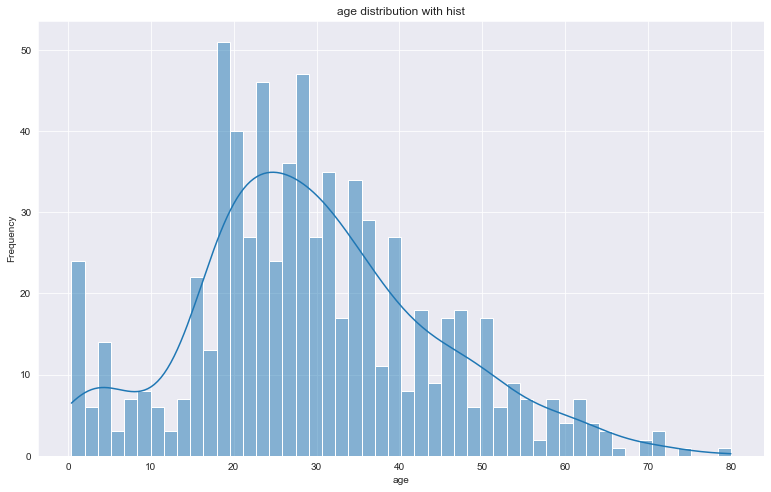

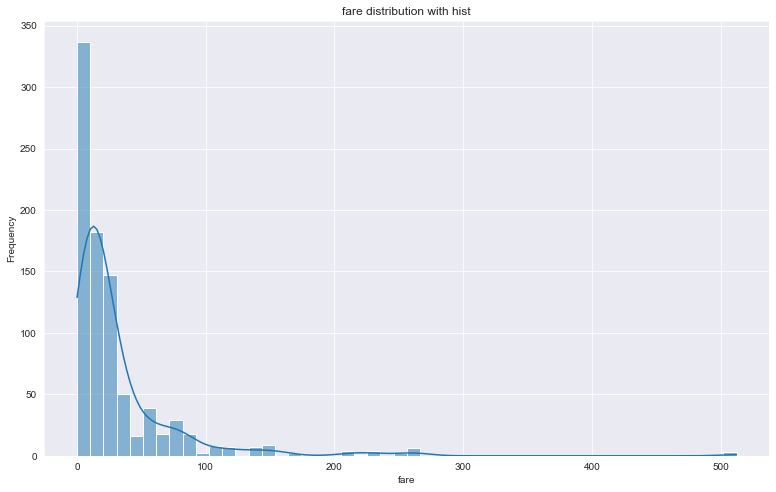

In [148]:
for c in NUMERICAL_VARIABLES:
    hist_plot(c, n_data)

We'll also go ahead and impute some data using the `MeanMedianImputer` class

In [149]:
median_imputation = MeanMedianImputer(imputation_method='median', variables=NUMERICAL_VARIABLES)
imputed_n_data = median_imputation.fit_transform(n_data)
imputed_n_data.head()

,age,fare
0,22.0,7.2500
1,38.0,71.2833
2,26.0,7.9250
3,35.0,53.1000
4,35.0,8.0500


In [150]:
imputed_n_data.describe()

,age,fare
count,891.000000,891.000000
mean,29.361582,32.204208
std,13.019697,49.693429
min,0.420000,0.000000
25%,22.000000,7.910400
50%,28.000000,14.454200
75%,35.000000,31.000000
max,80.000000,512.329200


Now that we have our numerical data in a better format, we can begin to handle some of the missing values. For one, we have to decide what to do about outliers. Lets have a look at them graphically:

## Categorial Data Exploration
Lets go ahead and look at only the categorical data:

In [129]:
c_data = data[CATEGORICAL_VARIABLES]
c_data["embarked"].unique()

array(['S', 'C', 'Q', nan], dtype=object)

In [130]:
c_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   pclass    891 non-null    int64 
 1   sex       891 non-null    object
 2   embarked  889 non-null    object
 3   survived  891 non-null    int64 
 4   sibsp     891 non-null    int64 
 5   parch     891 non-null    int64 
 6   cabin     204 non-null    object
dtypes: int64(4), object(3)
memory usage: 48.9+ KB


So we can see above, we have some values missing for `embarked` is missing only 2 which is pretty inconsequential. There is a pretty big problem with the `cabin` column though: almost 80% of the values are N/A! We'll have to explore this feature more, however lets first get an idea of the number of variables in each class. We do have a problem though... since the `sex` and `embarked` categories are `objects`, we need to convert them into categorical data instead:

In [131]:
CATEGORICAL_VARIABLES

['pclass', 'sex', 'embarked', 'survived', 'sibsp', 'parch', 'cabin']

In [132]:
sex_map = dict(zip(c_data["sex"].unique(), range(c_data["sex"].nunique())))
emb_map = dict(zip(c_data["embarked"].unique(), range(c_data["embarked"].nunique())))
surv_map = dict(zip(c_data["survived"].unique(), range(c_data["survived"].nunique())))
pclass_map = dict(zip(c_data["pclass"].unique(), range(c_data["pclass"].nunique())))

c_data_no_cabin = c_data.drop(columns="cabin")
c_data_no_cabin["sex"] = c_data_no_cabin["sex"].map(sex_map)
c_data_no_cabin["embarked"] = c_data_no_cabin["embarked"].map(emb_map, na_action="ignore")

In [133]:
c_data_no_cabin.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   pclass    891 non-null    int64  
 1   sex       891 non-null    int64  
 2   embarked  889 non-null    float64
 3   survived  891 non-null    int64  
 4   sibsp     891 non-null    int64  
 5   parch     891 non-null    int64  
dtypes: float64(1), int64(5)
memory usage: 41.9 KB


In [134]:
def bar_plot(variable, df, map_=None):
    """
       Taken from: https://www.kaggle.com/mertyalcindag/titanic-eda#Categorical-Variable
       
       input: Variable ex:"Sex"
       output: bar plot & value count
    """
    
    var = df[variable] # get feature
    varValue = var.value_counts() # count number of categorical variable
    
    # visualize
    plt.figure(figsize = (9,3))
    sns.barplot(x=varValue.index, y=varValue)
    # if map_:
    #   sns.barplot(x=map_[varValue.index], y=varValue)
    # else:
    #   sns.barplot(x=varValue.index, y=varValue)
      
    plt.ylabel("frequency")
    plt.title(variable)
    plt.show()
    print("{}: {}".format(variable,varValue)) 
    

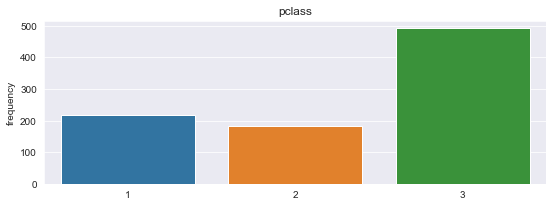

pclass: 3    491
1    216
2    184
Name: pclass, dtype: int64


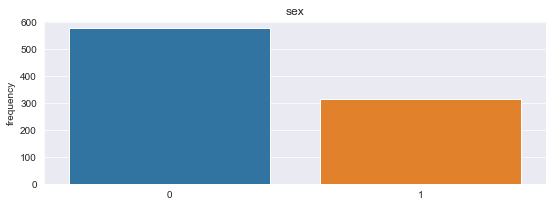

sex: 0    577
1    314
Name: sex, dtype: int64


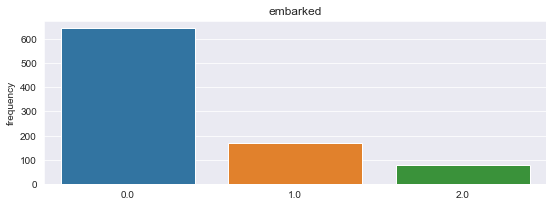

embarked: 0.0    644
1.0    168
2.0     77
Name: embarked, dtype: int64


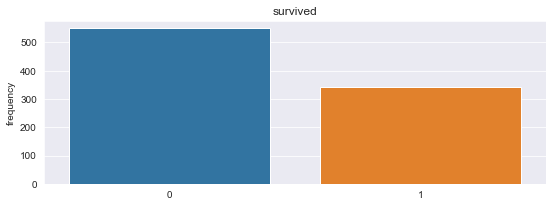

survived: 0    549
1    342
Name: survived, dtype: int64


In [135]:
bar_plot("pclass", c_data_no_cabin, map_=pclass_map)
bar_plot("sex", c_data_no_cabin, map_=sex_map)
bar_plot("embarked", c_data_no_cabin, map_=emb_map)
bar_plot("survived", c_data_no_cabin, map_=surv_map)

We can see here that there are definitely some imbalances in the data. This biggest example of this is the `embarked` column. This is something we may have to take care of by using **Sparse Sampling** during our prediction phase, however we will simply make a note of it for now.

In [136]:
# retain only the first cabin if more than
# 1 are available per passenger
def get_first_cabin(row):
    try:
        return row.split()[0]
    except:
        return np.nan
    
data['cabin'] = data['cabin'].apply(get_first_cabin)

In [137]:
# extracts the title (Mr, Ms, etc) from the name variable
def get_title(passenger):
    line = passenger
    if re.search('Mrs', line):
        return 'Mrs'
    elif re.search('Mr', line):
        return 'Mr'
    elif re.search('Miss', line):
        return 'Miss'
    elif re.search('Master', line):
        return 'Master'
    else:
        return 'Other'
    
data['title'] = data['name'].apply(get_title)

In [138]:
class ExtractLetterTransformer(BaseEstimator, TransformerMixin):
    # Extract fist letter of variable
    def __init__(self, variables):
        self.variables = variables

    def fit(self, X, y=None):
        # we need this step to fit the sklearn pipeline
        return self

    def transform(self, X):
        # so that we do not over-write the original dataframe
        X = X.copy()
        
        for feature in self.variables:
            X[feature] = X[feature].str[0]

        return X